<a href="https://colab.research.google.com/github/johan-naizu/solar-power-forecasting/blob/main/Solar%20Power%20Generation%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, Flatten, InputLayer
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/johan-naizu/dataset/refs/heads/main/dataset4.csv')
#df=df[df['power'] != 0]
df

,timestamp_utc,power,temp,cloud_cover,shortwave_flux
0,2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179
1,2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322
2,2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204
3,2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006
4,2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003
...,...,...,...,...,...
26696,2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055
26697,2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386
26698,2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398
26699,2016-06-28 14:00:00,12351.23189,290.743866,0.000000,933.213501


In [ ]:
df=df.set_index('timestamp_utc')
df=df.rename_axis('DateTime')
df

,power,temp,cloud_cover,shortwave_flux
DateTime,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003
...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398


In [ ]:
print(df.index.dtype)

object


In [ ]:
df.index = pd.to_datetime(df.index)
df['Seconds']=df.index.map(pd.Timestamp.timestamp)
df

,power,temp,cloud_cover,shortwave_flux,Seconds
DateTime,,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179,1.367158e+09
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322,1.367161e+09
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204,1.367165e+09
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006,1.367168e+09
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003,1.367172e+09
...,...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055,1.467112e+09
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386,1.467115e+09
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398,1.467119e+09


In [ ]:
print(df.index.dtype)

datetime64[ns]


In [ ]:
day = 60*60*24
year = 365.2425 * day
hour= 60*60

df['temp_cloud']=df['temp']*df['cloud_cover']
df['temp_shortwave']=df['temp']*df['shortwave_flux']

df['Day sin']=np.sin(df['Seconds'] * (2 * np.pi / day))
df['Day cos']=np.cos(df['Seconds'] * (2 * np.pi / day))
df['Year sin']=np.sin(df['Seconds'] * (2 * np.pi / year))
df['Year cos']=np.cos(df['Seconds'] * (2 * np.pi / year))
df['Hour sin']=np.sin(df['Seconds'] * (2 * np.pi / hour))
df['Hour cos']=np.cos(df['Seconds'] * (2 * np.pi / hour))

df

,power,temp,cloud_cover,shortwave_flux,Seconds,temp_cloud,temp_shortwave,Day sin,Day cos,Year sin,Year cos,Hour sin,Hour cos
DateTime,,,,,,,,,,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179,1.367158e+09,0.129851,236246.820786,-5.000000e-01,-8.660254e-01,0.895247,-0.445571,-2.413583e-11,1.0
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322,1.367161e+09,2.368855,192992.487392,-7.071068e-01,-7.071068e-01,0.894927,-0.446213,1.984414e-10,1.0
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204,1.367165e+09,50.091424,156901.436318,-8.660254e-01,-5.000000e-01,0.894607,-0.446854,-4.464258e-11,1.0
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006,1.367168e+09,49.100946,69029.279325,-9.659258e-01,-2.588190e-01,0.894286,-0.447495,1.779347e-10,1.0
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003,1.367172e+09,31.571706,20353.937843,-1.000000e+00,-7.565194e-12,0.893965,-0.448136,-6.514934e-11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055,1.467112e+09,14.527251,262062.611229,2.588190e-01,-9.659258e-01,0.057046,-0.998372,4.273988e-11,1.0
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386,1.467115e+09,37.806703,281742.360176,8.347672e-12,-1.000000e+00,0.056331,-0.998412,-2.003441e-10,1.0
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398,1.467119e+09,0.000000,284704.555765,-2.588190e-01,-9.659258e-01,0.055615,-0.998452,2.223313e-11,1.0


In [ ]:
df=df.drop('Seconds',axis=1)
df

,power,temp,cloud_cover,shortwave_flux,temp_cloud,temp_shortwave,Day sin,Day cos,Year sin,Year cos,Hour sin,Hour cos
DateTime,,,,,,,,,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179,0.129851,236246.820786,-5.000000e-01,-8.660254e-01,0.895247,-0.445571,-2.413583e-11,1.0
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322,2.368855,192992.487392,-7.071068e-01,-7.071068e-01,0.894927,-0.446213,1.984414e-10,1.0
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204,50.091424,156901.436318,-8.660254e-01,-5.000000e-01,0.894607,-0.446854,-4.464258e-11,1.0
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006,49.100946,69029.279325,-9.659258e-01,-2.588190e-01,0.894286,-0.447495,1.779347e-10,1.0
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003,31.571706,20353.937843,-1.000000e+00,-7.565194e-12,0.893965,-0.448136,-6.514934e-11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055,14.527251,262062.611229,2.588190e-01,-9.659258e-01,0.057046,-0.998372,4.273988e-11,1.0
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386,37.806703,281742.360176,8.347672e-12,-1.000000e+00,0.056331,-0.998412,-2.003441e-10,1.0
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398,0.000000,284704.555765,-2.588190e-01,-9.659258e-01,0.055615,-0.998452,2.223313e-11,1.0


In [ ]:
features = df.loc[:,['temp', 'cloud_cover','shortwave_flux','power']]
target = df.loc[:,['power']]

Text(0.5, 1.0, 'Temperature Time Series')

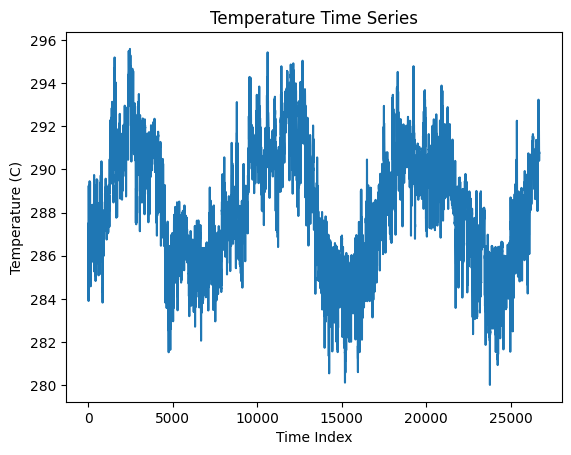

In [ ]:
plt.plot(features['temp'])
plt.xlabel('Time Index')
plt.ylabel('Temperature (C)')
plt.title('Temperature Time Series')


Text(0.5, 1.0, 'Cloud Cover Time Series(Magnified)')

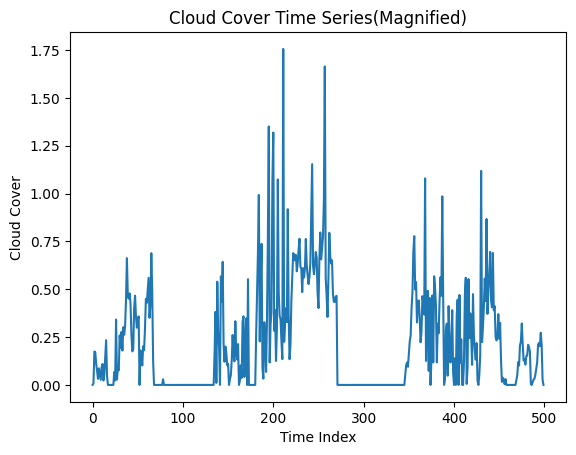

In [ ]:
plt.plot(features['cloud_cover'][:500])
plt.xlabel('Time Index')
plt.ylabel('Cloud Cover')
plt.title('Cloud Cover Time Series(Magnified)')

Text(0.5, 1.0, 'Shortwave Flux Time Series')

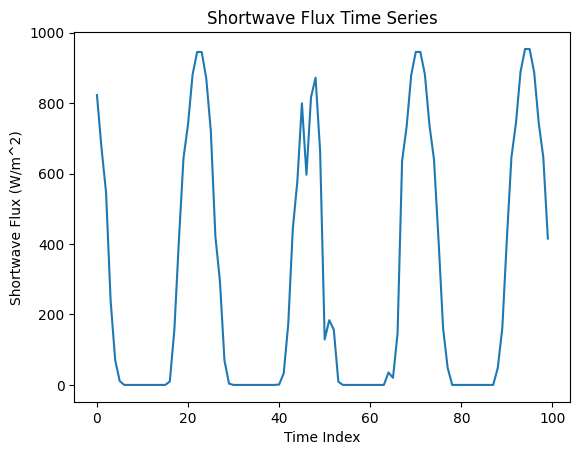

In [ ]:
plt.plot(features['shortwave_flux'][:100])
plt.xlabel('Time Index')
plt.ylabel('Shortwave Flux (W/m^2)')
plt.title('Shortwave Flux Time Series')

Text(0.5, 1.0, 'Power Time Series')

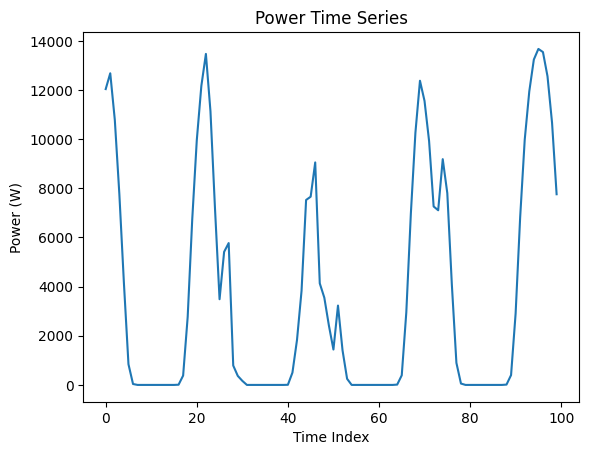

In [ ]:
plt.plot(features['power'][:100])
plt.xlabel('Time Index')
plt.ylabel('Power (W)')
plt.title('Power Time Series')

In [ ]:
features

,temp,cloud_cover,shortwave_flux,power
DateTime,,,,
2013-04-28 14:00:00,287.179138,0.000452,822.646179,12038.26346
2013-04-28 15:00:00,286.895630,0.008257,672.692322,12681.78416
2013-04-28 16:00:00,287.005615,0.174531,546.684204,10785.22227
2013-04-28 17:00:00,287.502197,0.170785,240.100006,7758.58862
2013-04-28 18:00:00,287.484985,0.109820,70.800003,4142.58465
...,...,...,...,...
2016-06-28 11:00:00,290.545013,0.050000,901.969055,10423.68080
2016-06-28 12:00:00,290.820801,0.130000,968.783386,11906.68229
2016-06-28 13:00:00,290.783264,0.000000,979.095398,12506.71949


In [ ]:
target

,power
DateTime,
2013-04-28 14:00:00,12038.26346
2013-04-28 15:00:00,12681.78416
2013-04-28 16:00:00,10785.22227
2013-04-28 17:00:00,7758.58862
2013-04-28 18:00:00,4142.58465
...,...
2016-06-28 11:00:00,10423.68080
2016-06-28 12:00:00,11906.68229
2016-06-28 13:00:00,12506.71949


In [ ]:
print(features.shape)
print(target.shape)

(14175, 4)
(14175, 1)


In [ ]:
features_scaler = MinMaxScaler()
features_scaled = features_scaler.fit_transform(features)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)
time_steps=48

In [ ]:
#Converting 2D to 3D (instead of np.reshape)
def Reshape(features,target,time_steps):
  new_features=[]
  new_target=[]
  for i in range(features.shape[0] - time_steps):
    new_features.append([features[j+i] for j in range(time_steps)])
    new_target.append(target[i+time_steps])
  return np.array(new_features),np.array(new_target)
X_data, y_data = Reshape(features_scaled,target_scaled,time_steps)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(14127, 48, 4)
(14127, 1)


In [ ]:
test_train_split= int(0.8*X_data.shape[0])
n_features=X_data.shape[2]

In [ ]:
X_train=X_data[:test_train_split]
y_train=y_data[:test_train_split]

X_test=X_data[test_train_split:]
y_test=y_data[test_train_split:]

In [ ]:
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)

print("X_test Shape: ", X_test.shape)
print("y_test Shape", y_test.shape)

print("Number of Features: ", n_features)

X_train Shape:  (11301, 48, 4)
y_train Shape:  (11301, 1)
X_test Shape:  (2826, 48, 4)
y_test Shape (2826, 1)
Number of Features:  4


In [ ]:
subsequences = 4
inner_timesteps = X_train.shape[1]//subsequences
X_train = X_train.reshape((X_train.shape[0], subsequences, inner_timesteps, n_features))

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)

print("X_test Shape: ", X_test.shape)
print("y_test Shape", y_test.shape)

print("Number of Features: ", n_features)

X_train Shape:  (11301, 4, 12, 4)
y_train Shape:  (11301, 1)
X_test Shape:  (2826, 48, 4)
y_test Shape (2826, 1)
Number of Features:  4


In [ ]:
model1=Sequential()
model1.add(InputLayer((subsequences,inner_timesteps,n_features)))
model1.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model1.add(TimeDistributed(Flatten()))
model1.add(LSTM(128, activation='tanh',return_sequences=False))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1 , activation='linear',kernel_regularizer=l2(0.02)))

In [ ]:
cp=ModelCheckpoint('model1.keras', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 4, 10, 64)           │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 4, 640)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4, 128)              │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4, 1)                │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,881 (1.54 MB)

 Trainable params: 402,881 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model1.fit(X_train, y_train, epochs=25, callbacks=[cp,es], validation_split=0.2)

Epoch 1/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.1089 - root_mean_squared_error: 0.2901 - val_loss: 0.0644 - val_root_mean_squared_error: 0.2431
Epoch 2/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0621 - root_mean_squared_error: 0.2413 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2344
Epoch 3/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0545 - root_mean_squared_error: 0.2300 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2235
Epoch 4/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0501 - root_mean_squared_error: 0.2213 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2134
Epoch 5/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0466 - root_mean_squared_error: 0.2138 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2133
Epoch 6/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0453 - root_mean_squared_error: 0.2110 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2055
Epoch 7/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 10

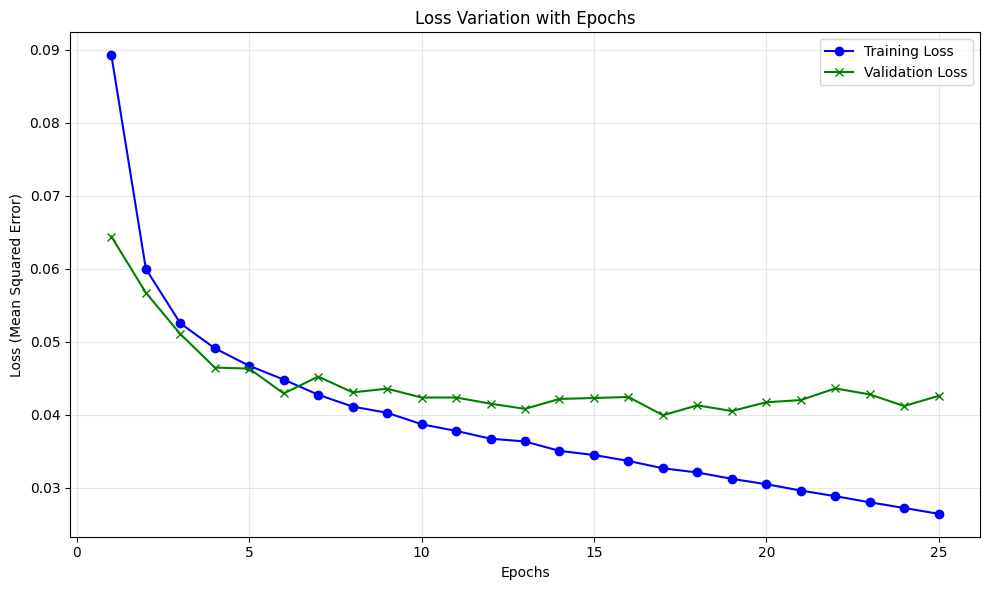

In [ ]:
train_loss = history.history['loss']  # Training loss
val_loss = history.history.get('val_loss')  # Validation loss (if validation data is used)

# Plotting the loss
epochs = range(1, len(train_loss) + 1)  # Epoch numbers

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='b', marker='o')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss', color='g', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Loss Variation with Epochs')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model1=load_model('model1.keras')

In [ ]:
#Evaluating Overfitting
train_predictions = model1.predict(X_train)
train_predictions = target_scaler.inverse_transform(train_predictions).flatten()
train_actuals = target_scaler.inverse_transform(y_train).flatten()
train_results=pd.DataFrame(data={'Predictions':train_predictions,'Actuals':train_actuals})
train_results

354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
print(train_results.shape)

In [ ]:
plt.plot(train_results['Predictions'][:100],label='Predicted')
plt.plot(train_results['Actuals'][:100],label='Actual')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Generated Power (W)')
plt.title("Temporal Prediction Visualization (Training Data)")
plt.show()

In [ ]:
rmse_train = np.sqrt(mean_squared_error(train_results['Predictions'], train_results['Actuals']))
Maximum_train=(train_results['Actuals']).max()
Mean_train=(train_results['Actuals']).mean()
accuracy_train1=100-(rmse_train/Maximum_train)*100
accuracy_train2=100-(rmse_train/Mean_train)*100
print(f"LSTM ACCURACY wrt Maximum: {accuracy_train1}")
print(f"LSTM ACCURACY wrt Mean: {accuracy_train2}")

In [ ]:
mae_train = mean_absolute_error(train_results['Actuals'],train_results['Predictions'])
mse_train = mean_squared_error(train_results['Actuals'],train_results['Predictions'])
mape_train = mean_absolute_percentage_error(train_results['Actuals'],train_results['Predictions'])
r2_train = r2_score(train_results['Actuals'],train_results['Predictions'])

In [ ]:
print("Mean Absolute Error = ", mae_train)
print("Mean Squared Error = ", mse_train)
print("Root Mean Squared Error =", rmse_train)
print("Mean Absolute Percentage Error =", mape_train)
print("r2 Score =", r2_train)

In [ ]:
X_test.shape

In [ ]:
#inner_timesteps = X_test.shape[1]//subsequences
X_test = X_test.reshape((X_test.shape[0], subsequences, inner_timesteps, n_features))
#X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)

print("X_test Shape: ", X_test.shape)
print("y_test Shape", y_test.shape)

print("Number of Features: ", n_features)

In [ ]:
#Test data
test_predictions = model1.predict(X_test)
test_predictions = target_scaler.inverse_transform(test_predictions).flatten()
test_actuals = target_scaler.inverse_transform(y_test).flatten()
test_results=pd.DataFrame(data={'Predictions':test_predictions,'Actuals':test_actuals})
test_results

In [ ]:
print(test_results.shape)

In [ ]:
plt.plot(test_results['Predictions'][:100],label='Predicted')
plt.plot(test_results['Actuals'][:100],label='Actual')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Generated Power (W)')
plt.title("Temporal Prediction Visualization (Testing Data)")
plt.show()

In [ ]:
rmse_test = np.sqrt(mean_squared_error(test_results['Predictions'], test_results['Actuals']))
Maximum_test=(test_results['Actuals']).max()
Mean_test=(test_results['Actuals']).mean()
accuracy_test1=100-(rmse_test/Maximum_test)*100
accuracy_test2=100-(rmse_test/Mean_test)*100
print(f"LSTM ACCURACY wrt Maximum: {accuracy_test1}")
print(f"LSTM ACCURACY wrt Mean: {accuracy_test2}")

In [ ]:
mae_test = mean_absolute_error(test_results['Actuals'],test_results['Predictions'])
mse_test = mean_squared_error(test_results['Actuals'],test_results['Predictions'])
mape_test = mean_absolute_percentage_error(test_results['Actuals'],test_results['Predictions'])
r2_test = r2_score(test_results['Actuals'],test_results['Predictions'])

In [ ]:
print("Mean Absolute Error = ", mae_test)
print("Mean Squared Error = ", mse_test)
print("Root Mean Squared Error =", rmse_test)
print("Mean Absolute Percentage Error =", mape_test)
print("r2 Score =", r2_test)

In [ ]:
residual_test=pd.DataFrame(data={'Residuals':test_results['Predictions']-test_results['Actuals']})
plt.plot(residual_test['Residuals'],label='Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.title("Residual Plot Magnified(Predictions - Actuals)")
plt.show()

In [ ]:
# Metrics for train and test data
metrics = ['RMSE', 'MAE', 'R² score * 1000']
train_scores = [rmse_train, mae_train , r2_train*1000]
test_scores = [1365.83, 868.44 , 890.2]
scores_df = pd.DataFrame({'Metrics': metrics, 'Train Scores': train_scores, 'Test Scores': test_scores})

# Positions for bar groups
x = np.arange(len(metrics))
width = 0.35

# Create the plot
plt.bar(x - width/2, scores_df['Train Scores'], width, label='Train', color='b', alpha=0.7)
plt.bar(x + width/2, scores_df['Test Scores'], width, label='Test', color='g', alpha=0.7)

for i, v in enumerate(scores_df['Train Scores']):
    plt.text(x[i] - width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

for i, v in enumerate(scores_df['Test Scores']):
    plt.text(x[i] + width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Train vs Test Metrics Comparison')
plt.xticks(x, scores_df['Metrics'])  # Add metric names as x-axis labels
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(residual_test['Residuals'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
plt.scatter(test_results['Actuals'], test_results['Predictions'], alpha=0.6, edgecolor='k')
plt.plot([min(test_results['Actuals']), max(test_results['Actuals'])],
         [min(test_results['Actuals']), max(test_results['Actuals'])],
         color='r', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Values (W)')
plt.ylabel('Predicted Values (W)')
plt.title('Predictions vs Actuals')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
residual_cumsum = residual_test['Residuals'].cumsum()
plt.plot(residual_cumsum, color='purple')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
plot_model(model1, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')